## Proofreading Tasks Ground Truth Analysis

Scalability & Analysis Team

1. Extract the data vectors and generate ground truth from maximum likelihood
2. implement PEAK gt extraction method and compare with expert proofreader data

In [1]:
# import relevant libaries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

Components for Simulation
1. 90 test cases to compare between majority rule method and score_dependent method to determine ground truth values

In [88]:
# read in the datafile 
data = pd.read_csv("proofreader_results.csv")

# call order_Tasks to extract relevant tables 
from PEAK_Data_Cleaning_Methods import order_Tasks, extract_proofreader_stats
df, assignees = order_Tasks(data)

# get stats for each proofreader
assignee_stats = extract_proofreader_stats(df)
new_df = df.copy()
new_df.drop(new_df[new_df['assignee_masked'] >= 1000].index, inplace = True)

##### Extract gt for the 90 test cases (to compare the two methods)

In [71]:
gt_test_cases = df.loc[df['assignee_masked'] == 1000]
test_cases = dict(zip(gt_test_cases.unique_task_id , gt_test_cases.decision))

#### Majority Rule Method

n ~ the number of proofreaders completing a specific proofreading task

$d_{i}$ ~ the decision made by proofreader $i$,  $1 \leq i \leq n$

The gt for the task will simply be the arg_majority ${[d_{1},d_{2},...,d_{n}]}$

Confidence probability $\in R$ ~ metric explaining the confidence of the decision

    - The proportion of proofreaders selecting this decision 

In [72]:
def extract_max_gt(task_id, data):
    data = df.loc[df['unique_task_id'] == task_id]
    decisions = data['decision'].to_list()
    max_decision = max(decisions,key=decisions.count)
    # design a metric called agreement rate
    rate = decisions.count(max_decision)/len(decisions)
    return max_decision, rate

#### Score-Dependent Rule Method (PEAK)

n ~ the number of proofreaders completing a specific proofreading task

$d_{i}$ ~ the decision made by proofreader $i$,  $1 \leq i \leq n$

Let $Y = [y_{1},y_{2},...y_{n}]$ ~ prior or posterior scores for each proofreader

Procedure
1. Apply a sigmoid transformation to each score $f(y_{i}) = z_{i}$

    ### $f(y) = \frac{1}{1 + e^{-c(y-0.5)}}$
    where c = steepness coefficient (default = 9)
2. For each unique decision d:
    - Compute the sum of transformed scores of the proofreaders who selected $d_{i}$
3. Select gt as the decision with max(sum(tranformed_Scores))


Confidence probability $\in R$ ~ metric explaining the confidence of the decision

    - The average score of the proofreaders from the selected gt decision 
    - This best represents our confidence in the decision since the method is strongly dependent on proofreader scores

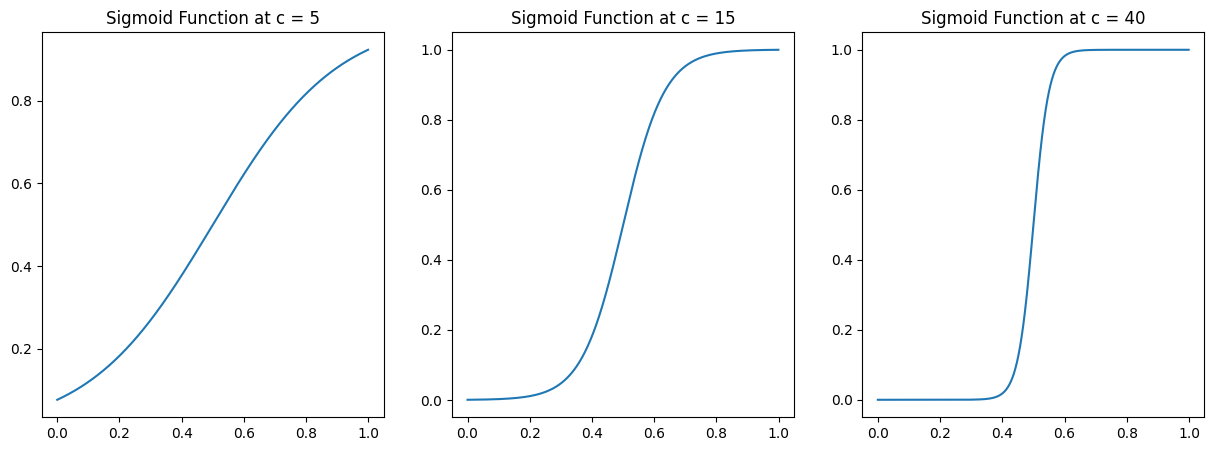

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt

x = np.arange(0,1,0.001)
y1 = (1+math.e**(-5*(x-0.5)))**(-1)
y2 = (1+math.e**(-40*(x-0.5)))**(-1)
y3 = (1+math.e**(-15*(x-0.5)))**(-1)


fig_1 = plt.figure(figsize = (15,5), facecolor='w',edgecolor='k')
plt.subplot(131)
plt.title('Sigmoid Function at c = 5')
plt.plot(x,y1)

plt.subplot(133)
plt.title('Sigmoid Function at c = 40')
plt.plot(x,y2)

plt.subplot(132)
plt.title('Sigmoid Function at c = 15')
plt.plot(x,y3)


In [73]:
def extract_gt(task_id, assignee_stats, df, c=9):
    '''
    Parameters:
        task_id (int-64) --> seg_id and task ID unique task indentifier 
        assignee (pandas dataframe) --> proofreader statistics for the proofreading tasks
        df (pandas dataframe) --> original proofreading tasks rslts dataframe
        c (float) --> steepness coefficient for the Sigmoid Function transform
    '''
    # extract original scores dictionary 
    scores_dict = dict(zip(assignee_stats.index , assignee_stats.average_accuracy))
    # create new diction to reframe to the transformed scores
    scores_dict_transf = {k: 1/(1+math.e**(-c*(v-0.5))) for k, v in scores_dict.items()}
    # extract the task results
    data = df.loc[df['unique_task_id'] == task_id]
    # pull out all the unique decisions for this task
    decisions = np.unique(data['decision'].to_list())

    decision_probabilities = {}
    for i in decisions:
        # filter this proofreading tasks by decision i
        decision_data = data.loc[data['decision'] == i]
        # extract each assignee id to their respective decision
        decision_dict = dict(zip(decision_data.assignee_masked, decision_data.decision))
        # total scores weights for decision i 
        sum = 0
        for key in decision_dict:
            sum += scores_dict_transf[key]

        decision_probabilities[i] = sum

    max_value = max(decision_probabilities, key=decision_probabilities.get)

    # now extract the confidence probability of this decision
    # no of people with this decision value
    count = data.loc[data['decision'] == i].shape[0]
    condfidence_prob = decision_probabilities[max_value]/count
    
    return max_value, condfidence_prob

In [ ]:
c = np.arange(2,15,0.25)


for i in c:
    # compute acc


In [84]:
def acc_rates(unique_task_ids):
    maj_rule_sum = 0
    score_dep_sum = 0
    conf_sum_maj_rule = 0
    conf_sum_score_dep = 0

    for i in unique_task_ids:
        maj_rule_method, confidence_maj_rule = extract_max_gt(i,new_df)
        score_dep_method, confidence_score_dep = extract_gt(i,assignee_stats,new_df)
        gt = test_cases[i]
        if maj_rule_method == gt:
            maj_rule_sum += 1
            conf_sum_maj_rule += confidence_maj_rule

        if score_dep_method == gt:
            score_dep_sum += 1
            conf_sum_score_dep += confidence_score_dep
    return maj_rule_sum/len(unique_task_ids), score_dep_sum/len(unique_task_ids)

unique_task_ids = np.unique(df['unique_task_id'].to_list())[0:90]

print('Overall preformance accuracy rate for Majority Rule Method', acc_rates(unique_task_ids)[0])
print('Overall preformance accuracy rate for Score-Dependent Rule Method', acc_rates(unique_task_ids)[1])


Overall preformance accuracy rate for Majority Rule Method 0.9
Overall preformance accuracy rate for Score-Dependent Rule Method 0.8888888888888888


Assessing Confidence probabilities and Accuracy rates

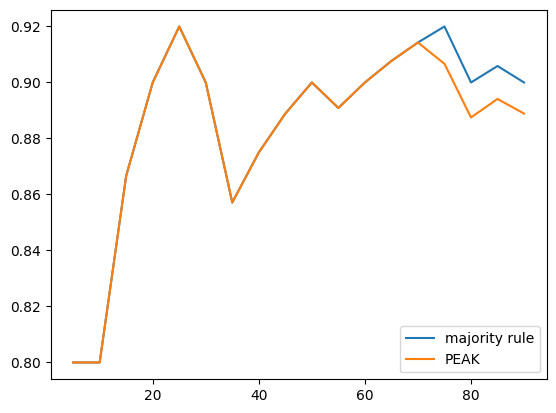

In [87]:
list_index = np.arange(5,95,5)
acc_maj_rule = []
acc_score_rule = []

for i in list_index:
    unique_task_ids = np.unique(df['unique_task_id'].to_list())[0:i]
    acc_maj_rule.append(acc_rates(unique_task_ids)[0])
    acc_score_rule.append(acc_rates(unique_task_ids)[1])

plt.plot(list_index,acc_maj_rule,label='majority rule')
plt.plot(list_index,acc_score_rule,label='PEAK')
plt.legend()
plt.show()